## Front-end Simulation

In [87]:
import numpy as np
import simpy
from collections import deque
import random
import matplotlib.pyplot as plt
from scipy.special import gamma

## Parameter Setting

In [88]:
battery_mean = 30  # Mean number of batteries per truck
total_trucks = 15
truck_load_sizes = [20, 40]

sim_duration = 240  
arrival_rate = total_trucks / sim_duration

In [89]:
env = simpy.Environment()

unloading_buffer = simpy.Container(env, capacity=500, init=0)  
loading_buffer = simpy.Container(env, capacity=500, init=300)

# Maintain a queue to track the number of batteries carried by each truck
truck_battery_queue = deque()

## Truck Arrival Process

In [90]:
def process_truck_arrival(env, unloading_buffer, battery_mean):
    truck_size = random.choice(truck_load_sizes)
    num_batteries = np.random.poisson(battery_mean)
    num_batteries = min(num_batteries, truck_size)
    truck_battery_queue.append(num_batteries)
    yield unloading_buffer.put(num_batteries)
    print(f'Truck (size {truck_size}) arrived with {num_batteries} depleted batteries at {env.now:.2f} minutes')

Compound Poisson

In [91]:
def truck_arrival_compound_poisson(env, unloading_buffer, battery_mean, arrival_rate):
    while True:
        yield env.timeout(random.expovariate(arrival_rate))
        env.process(process_truck_arrival(env, unloading_buffer, battery_mean))

Renewal Process (Weibull Distribution)

In [92]:
shape_parameter = 2
scale_parameter = battery_mean / gamma(1 + 1/shape_parameter)


def truck_arrival_renewal(env, unloading_buffer, battery_mean, scale_parameter, shape_parameter):
    while True:
        yield env.timeout(random.weibullvariate(scale_parameter, shape_parameter))
        env.process(process_truck_arrival(env, unloading_buffer, battery_mean))

Scheduled Arrival

In [93]:
batch_size = 3  # 5 batches in total
batch_interval = 48  # Time between batches in minutes (20 + 28min to discharge), 240 = 48 * 5
batch_window = 20  # Time for each batch to arrive 

def scheduled_batched_arrival(env, unloading_buffer, battery_mean, batch_size, batch_interval):
    start_time = 0
    while True:
        arrival_times = [random.uniform(start_time, start_time + batch_window) for _ in range(batch_size)]
        arrival_times.sort()

        for arrival_time in arrival_times:
            yield env.timeout(arrival_time - env.now)
            env.process(process_truck_arrival(env, unloading_buffer, battery_mean))

        yield env.timeout(start_time + batch_interval - env.now)
        start_time += batch_interval

## Processing Functions

In [94]:
# Function to process trucks at the loading buffer and charger station
def process_truck(env, unloading_buffer, loading_buffer):
    while True:
        while truck_battery_queue:
            num_batteries_needed = truck_battery_queue.popleft() 
            print(f'Need {num_batteries_needed} batteries.')
            
            while num_batteries_needed > loading_buffer.level:
                # Wait if there are not enough charged batteries in the loading buffer
                yield env.timeout(1)
                
            yield loading_buffer.get(num_batteries_needed)
            print(f'Truck loaded with {num_batteries_needed} charged batteries and left at {env.now:.2f} minutes. Now {loading_buffer.level} batteries in the loading buffer.')
        
        yield env.timeout(1)

# Function to periodically add charged batteries to the loading buffer (actually CCS)
def replenish_loading_buffer(env, loading_buffer):
    while True:
        yield env.timeout(10)  # Adjust the time interval for replenishment
        num_batteries_added = 10  # Adjust the number of batteries added
        yield loading_buffer.put(num_batteries_added)
        print(f'Added {num_batteries_added} charged batteries to loading buffer at {env.now:.2f} minutes. Now {loading_buffer.level} batteries in the loading buffer.')


In [95]:
# Lists to store simulation data for visualization
time_points = []
loading_buffer_levels = []
unloading_buffer_levels = []

# Function to update data for visualization
def record_data(env, loading_buffer, unloading_buffer):
    while True:
        time_points.append(env.now)
        loading_buffer_levels.append(loading_buffer.level)
        unloading_buffer_levels.append(unloading_buffer.level)
        yield env.timeout(1)  # Record data every minute


In [96]:
# Plotting function
def plot_buffer_levels(time_points, loading_buffer_levels, unloading_buffer_levels):
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, loading_buffer_levels, label='Loading Buffer')
    plt.plot(time_points, unloading_buffer_levels, label='Unloading Buffer')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Buffer Level')
    plt.legend()
    plt.title('Loading and Unloading Buffer Levels Over Time')
    plt.grid(True)
    plt.show()

## Run Environment

In [97]:
arrival_process = 'scheduled'

if arrival_process == 'compound_poisson':
    env.process(truck_arrival_compound_poisson(env, unloading_buffer, battery_mean, arrival_rate))
elif arrival_process == 'renewal': 
    env.process(truck_arrival_renewal(env, unloading_buffer, battery_mean, scale_parameter, shape_parameter))
elif arrival_process == 'scheduled':
    env.process(scheduled_batched_arrival(env, unloading_buffer, battery_mean, batch_size, batch_interval))

env.process(process_truck(env, unloading_buffer, loading_buffer))
env.process(replenish_loading_buffer(env, loading_buffer))
env.process(record_data(env, loading_buffer, unloading_buffer))


# Run the simulation
env.run(until=sim_duration)

print("Simulation finished."  )

Truck (size 20) arrived with 18 depleted batteries at 0.85 minutes
Need 18 batteries.
Truck loaded with 18 charged batteries and left at 1.00 minutes. Now 282 batteries in the loading buffer.
Truck (size 40) arrived with 31 depleted batteries at 3.98 minutes
Need 31 batteries.
Truck loaded with 31 charged batteries and left at 4.00 minutes. Now 251 batteries in the loading buffer.
Truck (size 40) arrived with 37 depleted batteries at 7.94 minutes
Need 37 batteries.
Truck loaded with 37 charged batteries and left at 8.00 minutes. Now 214 batteries in the loading buffer.
Added 10 charged batteries to loading buffer at 10.00 minutes. Now 224 batteries in the loading buffer.
Added 10 charged batteries to loading buffer at 20.00 minutes. Now 234 batteries in the loading buffer.
Added 10 charged batteries to loading buffer at 30.00 minutes. Now 244 batteries in the loading buffer.
Added 10 charged batteries to loading buffer at 40.00 minutes. Now 254 batteries in the loading buffer.
Added 10

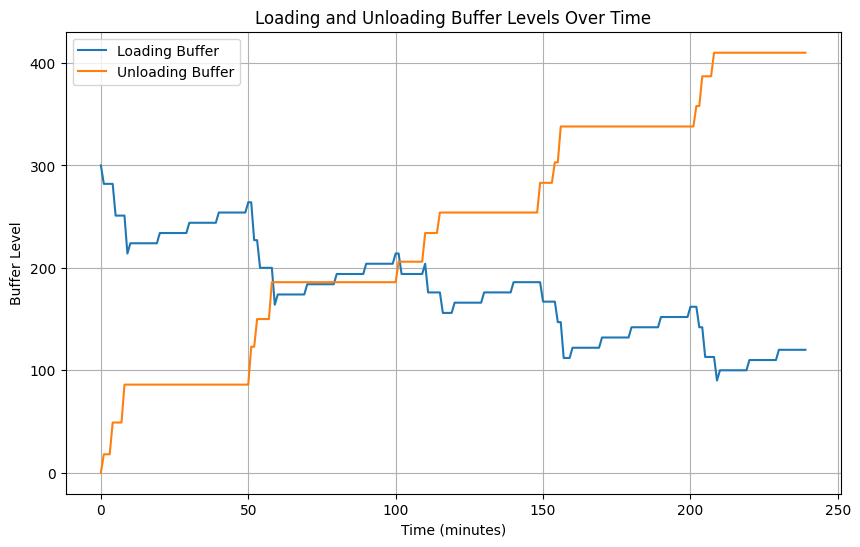

In [98]:
plot_buffer_levels(time_points, loading_buffer_levels, unloading_buffer_levels)